[![PyPI version](https://badge.fury.io/py/poola.svg)](https://badge.fury.io/py/poola)

# poola

> Python package for pooled screen analysis

## Install

Install from github for the latest development release:

`pip install git+git://github.com/gpp-rnd/poola.git#egg=poola`

Or install the most recent distribution from PyPi:

`pip install poola`

## How to use

Additional packages required for this tutorial can be install using `pip install -r requirements.txt`

In [ ]:
from poola import core as pool
import pandas as pd
import seaborn as sns
import gpplot
import matplotlib.pyplot as plt

To demonstrate the functionality of this module we'll use read counts from [Sanson et al. 2018](https://doi.org/10.1038/s41467-018-07901-8).

In [ ]:
supp_reads = 'https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-018-07901-8/MediaObjects/41467_2018_7901_MOESM4_ESM.xlsx'
read_counts = pd.read_excel(supp_reads,
                            sheet_name = 'A375_orig_tracr raw reads', 
                            header = None,
                            skiprows = 3, 
                            names = ['sgRNA Sequence', 'pDNA', 'A375_RepA', 'A375_RepB'], 
                            engine='openpyxl')
guide_annotations = pd.read_excel(supp_reads,
                                  sheet_name='sgRNA annotations', 
                                  engine='openpyxl')

The input data has three columns with read counts and one column with sgRNA annotations

In [ ]:
read_counts.head()

,sgRNA Sequence,pDNA,A375_RepA,A375_RepB
0,AAAAAAAATCCGGACAATGG,522,729,774
1,AAAAAAAGGATGGTGATCAA,511,1484,1393
2,AAAAAAATGACATTACTGCA,467,375,603
3,AAAAAAATGTCAGTCGAGTG,200,737,506
4,AAAAAACACAAGCAAGACCG,286,672,352


In [ ]:
lognorms = pool.lognorm_columns(reads_df=read_counts, columns=['pDNA', 'A375_RepA', 'A375_RepB'])
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['pDNA'], z_low=-3)
print('Filtered ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]) + ' columns due to low pDNA abundance')

Filtered 576 columns due to low pDNA abundance


Note that the column names for the lognorms remain the same

In [ ]:
lognorms.head()

,sgRNA Sequence,pDNA,A375_RepA,A375_RepB
0,AAAAAAAATCCGGACAATGG,4.192756,3.373924,3.521755
1,AAAAAAAGGATGGTGATCAA,4.163726,4.326828,4.312620
2,AAAAAAATGACATTACTGCA,4.041390,2.540624,3.196767
3,AAAAAAATGTCAGTCGAGTG,2.930437,3.388159,2.973599
4,AAAAAACACAAGCAAGACCG,3.388394,3.268222,2.528233


In [ ]:
lfc_df = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='pDNA', target_cols=['A375_RepA', 'A375_RepB'])

We drop the pDNA column after calculating log-fold changes

In [ ]:
lfc_df.head()

,sgRNA Sequence,A375_RepA,A375_RepB
0,AAAAAAAATCCGGACAATGG,-0.818831,-0.671000
1,AAAAAAAGGATGGTGATCAA,0.163102,0.148894
2,AAAAAAATGACATTACTGCA,-1.500766,-0.844622
3,AAAAAAATGTCAGTCGAGTG,0.457721,0.043161
4,AAAAAACACAAGCAAGACCG,-0.120172,-0.860161


Since we only have two conditions it's easy to visualize replicates as a point densityplot using [gpplot](https://github.com/gpp-rnd/gpplot)

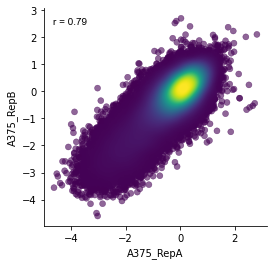

In [ ]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_df, x='A375_RepA', y='A375_RepB')
gpplot.add_correlation(data=lfc_df, x='A375_RepA', y='A375_RepB')
sns.despine()

Since we see a strong correlation, we'll average the log-fold change of each sgRNA across replicates

In [ ]:
avg_replicate_lfc_df = pool.average_replicate_lfcs(lfcs=lfc_df, guide_col='sgRNA Sequence', condition_indices=[0], sep='_')

After averaging log-fold changes our dataframe is melted, so the condition column specifies the experimental condition (A375 here) and the n_obs specifies the number of replicates

In [ ]:
avg_replicate_lfc_df.head()

,sgRNA Sequence,condition,avg_lfc,n_obs
0,AAAAAAAATCCGGACAATGG,A375,-0.744916,2
1,AAAAAAAGGATGGTGATCAA,A375,0.155998,2
2,AAAAAAATGACATTACTGCA,A375,-1.172694,2
3,AAAAAAATGTCAGTCGAGTG,A375,0.250441,2
4,AAAAAACACAAGCAAGACCG,A375,-0.490166,2


Before combining sgRNAs at the gene level, it's sometimes helpful to group controls into pseudo-genes so they're easier to compare with target genes. Our annotation file maps from sgRNA sequences to gene symbols

In [ ]:
remapped_annotations = pool.group_pseudogenes(annotations=guide_annotations, pseudogene_size=4, 
                                              gene_col='Annotated Gene Symbol', 
                                              control_regex=['NO_CURRENT'])
remapped_annotations.head()

,sgRNA Sequence,Annotated Gene Symbol,Annotated Gene ID
0,AAAAAAAATCCGGACAATGG,SLC25A24,29957
1,AAAAAAAGGATGGTGATCAA,FASTKD3,79072
2,AAAAAAATGACATTACTGCA,BCAS2,10286
3,AAAAAAATGTCAGTCGAGTG,GPR18,2841
4,AAAAAACACAAGCAAGACCG,ZNF470,388566


Using this remapped annotations file, we'll average log-fold changes for each gene, and calculate z-scores using the nonessential genes as controls. When `z_score_neg_ctls=True`, we can specify `z_score_neg_ctl_genes` as a list or regex to specify genes for our null distribution. Note that if `z_score_neg_ctl_genes=None` then all genes are used to generate the null

In [ ]:
nonessential_genes = (pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt', 
                                    names=['gene'])
                      .gene)
gene_lfcs = pool.average_gene_lfcs(lfcs=avg_replicate_lfc_df, annotations=remapped_annotations, gene_col='Annotated Gene Symbol',
                                   merge_on='sgRNA Sequence', z_score_neg_ctls=True, 
                                   z_score_neg_ctl_genes=nonessential_genes)

From our z-scores we calculate a p-value and FDR using the [Benjamini-Hochberg procedure](http://www.biostathandbook.com/multiplecomparisons.html)

In [ ]:
gene_lfcs.sort_values('z_scored_avg_lfc').head()

,condition,Annotated Gene Symbol,avg_lfc,n_obs,z_scored_avg_lfc,z_scored_avg_lfc_p_value,z_scored_avg_lfc_fdr_bh
13317,A375,PSMG3,-3.165679,4,-13.076520,4.485080e-39,8.684460e-35
7375,A375,HSPA5,-3.021085,4,-12.492789,8.173727e-36,7.913393e-32
4927,A375,EIF6,-3.009939,4,-12.447794,1.437640e-35,9.279010e-32
14219,A375,RPL19,-2.993390,4,-12.380987,3.312447e-35,1.603473e-31
12774,A375,POLR2L,-2.970395,4,-12.288152,1.048764e-34,4.061445e-31


Finally, to evaluate the quality this screen, we'll calculate the ROC-AUC between [essential](https://doi.org/10.1016/j.cell.2015.11.015) and [nonessential](https://doi.org/10.15252/msb.20145216) genes for each condition

In [ ]:
essential_genes = (pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt', 
                                 names=['gene'])
                   .gene)
roc_aucs = pool.get_roc_aucs(lfcs=gene_lfcs, tp_genes=essential_genes, fp_genes=nonessential_genes, 
                             gene_col='Annotated Gene Symbol', score_col='avg_lfc', group_col='condition')
print('ROC-AUC: ' + str(round(roc_aucs['ROC-AUC'].values[0], 3)))

ROC-AUC: 0.976


Note that we can also use this function to calculate roc-aucs at the guide level

In [ ]:
annotated_guide_lfcs = lfc_df.merge(guide_annotations, how='inner', on='sgRNA Sequence')
roc_aucs = pool.get_roc_aucs(lfcs=annotated_guide_lfcs, tp_genes=essential_genes, fp_genes=nonessential_genes, gene_col='Annotated Gene Symbol',
                             conditions=['A375_RepA', 'A375_RepB'])
print('Rep A AUC: ' + str(round(roc_aucs.loc[roc_aucs.condition == 'A375_RepA', 'ROC-AUC'].values[0], 4)))
print('Rep B AUC: ' + str(round(roc_aucs.loc[roc_aucs.condition == 'A375_RepB', 'ROC-AUC'].values[0], 4)))

Rep A AUC: 0.9185
Rep B AUC: 0.9176
